<a href="https://colab.research.google.com/github/AirNicco8/NLP_Assignments/blob/main/Assignment_2/Assignment_2_avg_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model in particular uses:

1. **Sentence Embedding** ->  Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
2.  **Input Merging** -> Mean: define the classification input as the mean of evidence and claim sentence embeddings



# Imports

In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 22.5 MB/s 


In [194]:
import os
import datetime
import requests
import zipfile

import pandas as pd
import re
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Bidirectional, TimeDistributed, Dense, InputLayer, Embedding, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Dataset download & Splitting

In [5]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [6]:
test_name = "test_pairs.csv"
train_name = "train_pairs.csv"
val_name = "val_pairs.csv"


test_path = os.path.join(os.getcwd(), "dataset", test_name)
train_path = os.path.join(os.getcwd(), "dataset", train_name)
val_path = os.path.join(os.getcwd(), "dataset", val_name)

test_pairs = pd.read_csv(test_path);
train_pairs = pd.read_csv(train_path);
val_pairs = pd.read_csv(val_path);

In [7]:
train_pairs.head()

,Unnamed: 0,Claim,Evidence,ID,Label
0,0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


In [8]:
train_set = train_pairs.drop(['Unnamed: 0', 'ID'], axis=1)
train_set.head()

,Claim,Evidence,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,REFUTES


In [9]:
val_set = val_pairs.drop(['Unnamed: 0', 'ID'], axis=1)
val_set.head()

,Claim,Evidence,Label
0,The Indian Army comprises part of the country'...,16\tIt is an all-volunteer force and comprises...,SUPPORTS
1,Recovery features Rihanna.,6\tEminem also collaborated with artists such ...,SUPPORTS
2,Rihanna is on Recovery.,6\tEminem also collaborated with artists such ...,SUPPORTS
3,Philomena was nominated.,8\tThe film was nominated in four categories a...,SUPPORTS
4,Vietnam is a mascot.,0\tVietnam -LRB- ˌ ; -LSB- vîət nāːm -RSB- -RR...,REFUTES


In [10]:
test_set = test_pairs.drop(['Unnamed: 0', 'ID'], axis=1)
test_set.head()

,Claim,Evidence,Label
0,Anxiety has been linked with physical symptoms.,"13\tFurthermore , anxiety has been linked with...",SUPPORTS
1,Firefox is an application.,0\tMozilla Firefox -LRB- or simply Firefox -RR...,SUPPORTS
2,Keegan-Michael Key played President Barack Oba...,"6\tIn 2015 , Key appeared at the White House C...",SUPPORTS
3,Google Search can find stock quotes.,"13\tThese include synonyms , weather forecasts...",SUPPORTS
4,A Good Day to Die Hard was directed solely by ...,1\tThe film was directed by John Moore and wri...,REFUTES


# Pre Processing

In [11]:
train_labels = train_set.Label
val_labels = val_set.Label
test_labels = test_set.Label

In [12]:
s_train_claims = train_set.Claim
s_val_claims = val_set.Claim
s_test_claims = test_set.Claim

In [13]:
# convert claims in lists for tokenization
train_claims = []
val_claims = []
test_claims = []

for i in s_train_claims:
  train_claims.append(i)

for i in s_val_claims:
  val_claims.append(i)

for i in s_test_claims:
  test_claims.append(i)

In [14]:
train_df = pd.DataFrame(columns=['Claim', 'Evidence', 'Label'])

train_evidences = train_set.Evidence
val_evidences = val_set.Evidence
test_evidences = test_set.Evidence

In [15]:
train_evidences[0]

'2\tHemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LRB- 2012 -RRB- , the dark-fantasy action film Snow White and the Huntsman -LRB- 2012 -RRB- , the war film Red Dawn -LRB- 2012 -RRB- , and the biographical sports drama film Rush -LRB- 2013 -RRB- .\tStar Trek\tStar Trek (film)\tA Perfect Getaway\tA Perfect Getaway\tThe Cabin in the Woods\tThe Cabin in the Woods\tSnow White and the Huntsman\tSnow White and the Huntsman\tRed Dawn\tRed Dawn (2012 film)\tRush\tRush (2013 film)'

In [16]:
# compile regex to avoid multiple computations
splitter = re.compile(r' \.')
beginline = re.compile(r'\d+\t')
parenthesis = re.compile(r'\-[A-Z]{3}\-')
phonetics = re.compile(r'[^a-zA-Z\d\s:\u00C0-\u00FF!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]*')

In [17]:
#evidences text cleaning
k=0
clean_train_evidences = []
clean_val_evidences = []
clean_test_evidences = []

for i in train_evidences:
  tmp = re.split(splitter,i)[0]
  tmp = re.sub(beginline, '', tmp)
  if k == 12:
     print(tmp)
  tmp = re.sub(parenthesis, '', tmp)
  tmp = re.sub(phonetics, '', tmp)
  clean_train_evidences.append(tmp)
  k += 1

for i in val_evidences:
  tmp = re.split(splitter,i)[0]
  tmp = re.sub(beginline, '', tmp)
  tmp = re.sub(parenthesis, '', tmp)
  tmp = re.sub(phonetics, '', tmp)
  clean_val_evidences.append(tmp)

for i in test_evidences:
  tmp = re.split(splitter,i)[0]
  tmp = re.sub(beginline, '', tmp)
  tmp = re.sub(parenthesis, '', tmp)
  tmp = re.sub(phonetics, '', tmp)
  clean_test_evidences.append(tmp)

Greece -LRB- Ελλάδα , -LSB- eˈlaða -RSB- -RRB- , officially the Hellenic Republic -LRB- Greek : Ελληνική Δημοκρατία , -LSB- eliniˈci ðimokraˈti.a -RSB- -RRB- , historically also known as Hellas -LRB- Ἑλλάς , -LSB- heˈlas -RSB- , modern pronunciation Ellás -RRB- , is a country in southeastern Europe , with a population of approximately 11 million as of 2015


In [18]:
val_evidences[62]
# maybe needs more cleaning? i assume from now on we have clean data

'6\tHitchcock became a highly visible public figure through interviews , movie trailers , cameo appearances in his own films , and the ten years in which he hosted the television programme Alfred Hitchcock Presents -LRB- 1955 -- 1965 -RRB- .\tcameo appearances\tList of Alfred Hitchcock cameo appearances\tAlfred Hitchcock Presents\tAlfred Hitchcock Presents'

In [19]:
clean_val_evidences[62]

'Hitchcock became a highly visible public figure through interviews , movie trailers , cameo appearances in his own films , and the ten years in which he hosted the television programme Alfred Hitchcock Presents  1955 -- 1965 '

# Tokenization
- padding

In [20]:
# concatenate splits lists for tokenizer input
claim_to_vocab = train_claims + val_claims + test_claims
evidences_to_vocab = clean_train_evidences + clean_val_evidences + clean_test_evidences

In [21]:
claim_tokenizer = Tokenizer(lower=False)                     # instantiate tokeniser
claim_tokenizer.fit_on_texts(claim_to_vocab)                    # fit tokeniser on data

In [22]:
evidence_tokenizer = Tokenizer(lower=False)                     
evidence_tokenizer.fit_on_texts(evidences_to_vocab)

###Glove

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-12-23 15:14:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-23 15:14:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 15:14:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
path_to_glove_file = os.path.join(os.getcwd(), "glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Embedding matrix for claims

In [25]:
num_tokens = len(claim_tokenizer.index_word) + 1
embedding_dim = 100
hits = 0
misses = 0


# Prepare embedding matrix
embedding_matrix_c = np.zeros((num_tokens, embedding_dim))
for word, i in claim_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_c[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix_c += np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10970 words (13832 misses)


Embedding matrix for Evidence

In [26]:
num_tokens = len(evidence_tokenizer.index_word) + 1
embedding_dim = 100
hits = 0
misses = 0


# Prepare embedding matrix
embedding_matrix_e = np.zeros((num_tokens, embedding_dim))
for word, i in evidence_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_e[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix_e += np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15376 words (22592 misses)


In [136]:
def to_cat(y, tokenizer): # map labels to one hot encoding
  tokenizer.fit_on_texts(y)
  y = tokenizer.texts_to_sequences(y)
  y = tf.keras.utils.to_categorical(y, num_classes=None, dtype='int')
  return y

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(train_labels)

train_labels_y =  to_cat(train_labels, tokenizer_y)
val_labels_y = to_cat(val_labels, tokenizer_y)
test_labels_y = to_cat(test_labels, tokenizer_y)

In [137]:
# drop first column, all zeros
train_labels_y = train_labels_y[:,1:3]
val_labels_y = val_labels_y[:,1:3]
test_labels_y = test_labels_y[:,1:3]

In [30]:
# from text to integers
train_claims_X = claim_tokenizer.texts_to_sequences(train_claims)
val_claims_X = claim_tokenizer.texts_to_sequences(val_claims)
test_claims_X = claim_tokenizer.texts_to_sequences(test_claims)

train_evidences_X = evidence_tokenizer.texts_to_sequences(clean_train_evidences)
val_evidences_X = evidence_tokenizer.texts_to_sequences(clean_val_evidences)
test_evidences_X = evidence_tokenizer.texts_to_sequences(clean_test_evidences)

###Padding

In [31]:
MAX_CLAIM_LENGTH = max(len(max(train_claims_X, key=len)), len(max(val_claims_X, key=len)), len(max(test_claims_X, key=len)))
MAX_CLAIM_LENGTH

65

In [32]:
MAX_EVIDENCE_LENGTH = max(len(max(train_evidences_X, key=len)), len(max(val_evidences_X, key=len)), len(max(test_evidences_X, key=len)))
MAX_EVIDENCE_LENGTH

209

In [33]:
def pad(set, max): # padding function
  return pad_sequences(set, maxlen=max, padding='post')

In [34]:
train_claims_X = pad(train_claims_X, MAX_CLAIM_LENGTH)
val_claims_X = pad(val_claims_X, MAX_CLAIM_LENGTH)
test_claims_X = pad(test_claims_X, MAX_CLAIM_LENGTH)

train_evidences_X = pad(train_evidences_X, MAX_EVIDENCE_LENGTH)
val_evidences_X = pad(val_evidences_X, MAX_EVIDENCE_LENGTH)
test_evidences_X = pad(test_evidences_X, MAX_EVIDENCE_LENGTH)

# Model Implementation

In [35]:
embedded_dimension = 100

##1. Encode token sequences via a RNN and take the last state as the sentence embedding.

In [36]:
# input layers
evidence_input_layer = keras.Input(shape=(MAX_EVIDENCE_LENGTH, ))
claim_input_layer = keras.Input(shape=(MAX_CLAIM_LENGTH, ))

claim_input = claim_input_layer
evidence_input = evidence_input_layer

# Embeddings
claims_embedding_layer = tf.keras.layers.Embedding(
    len(claim_tokenizer.word_index)+1,
    embedded_dimension,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_c),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_CLAIM_LENGTH
)

evidences_embedding_layer = tf.keras.layers.Embedding(
    len(evidence_tokenizer.word_index)+1,
    embedded_dimension,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_e),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_EVIDENCE_LENGTH
)

x1 = claims_embedding_layer(claim_input)
x2 = evidences_embedding_layer(evidence_input)

x1 = Bidirectional(LSTM(units=int(embedded_dimension/4),
                          return_sequences=False))(x1) 

x2 = Bidirectional(LSTM(units=int(embedded_dimension/4), 
                          return_sequences=False))(x2) 

# Merge layer
mean_x = tf.keras.layers.Average()([x1,x2])

# dropout
dropout = tf.keras.layers.Dropout(0.25)(mean_x)

# classification final layer
outputs = layers.Dense(3, activation='softmax')(dropout)

model_RNN_last = keras.Model(inputs=[claim_input, evidence_input], outputs=outputs, name="RNN_last")
model_RNN_last.summary()

Model: "RNN_last"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 209)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 65, 100)      2480300     ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 209, 100)     3796900     ['input_1[0][0]']                
                                                                                           

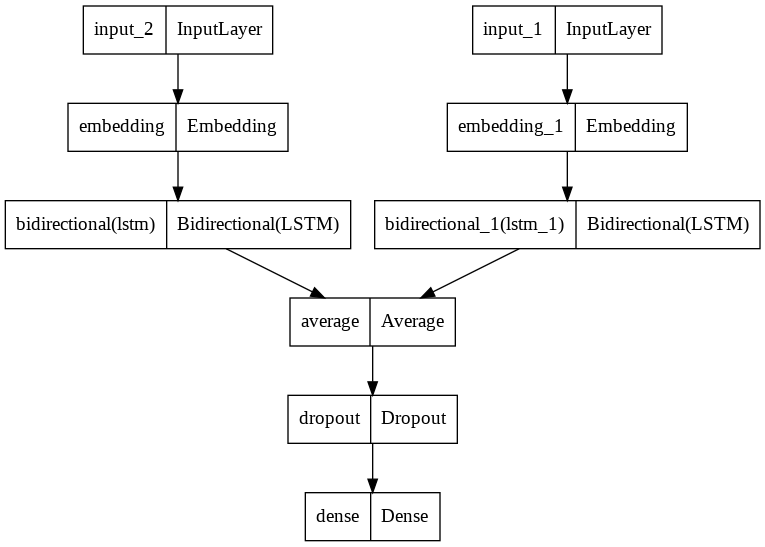

In [37]:
keras.utils.plot_model(model_RNN_last, "RNN_last.png")

## 2. Encode token sequences via a RNN and average all the output states.

In [38]:
# input layers
evidence_input_layer = keras.Input(shape=(MAX_EVIDENCE_LENGTH, ))
claim_input_layer = keras.Input(shape=(MAX_CLAIM_LENGTH, ))

claim_input = claim_input_layer
evidence_input = evidence_input_layer

# Embeddings
claims_embedding_layer = tf.keras.layers.Embedding(
    len(claim_tokenizer.word_index)+1,
    embedded_dimension,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_c),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_CLAIM_LENGTH
)

evidences_embedding_layer = tf.keras.layers.Embedding(
    len(evidence_tokenizer.word_index)+1,
    embedded_dimension,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_e),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_EVIDENCE_LENGTH
)

x1 = claims_embedding_layer(claim_input)
x2 = evidences_embedding_layer(evidence_input)

x1 = LSTM(units=int(embedded_dimension/4),
                          return_sequences=True)(x1) 

x2 = LSTM(units=int(embedded_dimension/4),
                          return_sequences=True)(x2) 

x1 = tf.reduce_mean(x1, 1)
x2 = tf.reduce_mean(x2, 1)

# Merge layer
mean_x = tf.keras.layers.Average()([x1,x2])

# classification final layer

outputs = layers.Dense(2, activation='softmax')(mean_x)

model_RNN_mean = keras.Model(inputs=[claim_input, evidence_input], outputs=outputs, name="RNN_mean")
model_RNN_mean.summary()

Model: "RNN_mean"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 209)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 65, 100)      2480300     ['input_4[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 209, 100)     3796900     ['input_3[0][0]']                
                                                                                           

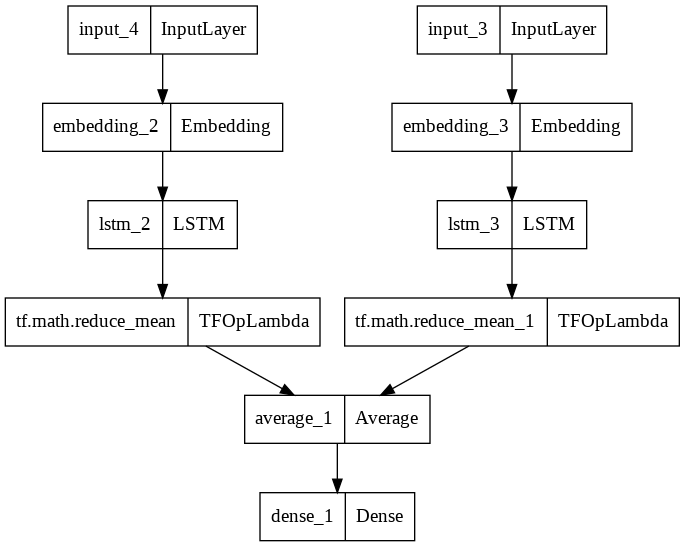

In [39]:
keras.utils.plot_model(model_RNN_mean, "RNN_mean.png")

## 3. Encode token sequences via a simple MLP layer. 
- this model is chosen to test all merging strategies and the cosine similarity extension

In [191]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [199]:
def create_mlp_model(merge):
  # input layers
  evidence_input_layer = keras.Input(shape=(MAX_EVIDENCE_LENGTH, ))
  claim_input_layer = keras.Input(shape=(MAX_CLAIM_LENGTH, ))

  claim_input = claim_input_layer
  evidence_input = evidence_input_layer

  # Embeddings
  claims_embedding_layer = tf.keras.layers.Embedding(
      len(claim_tokenizer.word_index)+1,
      embedded_dimension,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix_c),
      trainable = True,
      embeddings_regularizer=None,
      activity_regularizer=None,
      embeddings_constraint=None,
      mask_zero=False,
      input_length=MAX_CLAIM_LENGTH
  )

  evidences_embedding_layer = tf.keras.layers.Embedding(
      len(evidence_tokenizer.word_index)+1,
      embedded_dimension,
      embeddings_initializer=keras.initializers.Constant(embedding_matrix_e),
      trainable = True,
      embeddings_regularizer=None,
      activity_regularizer=None,
      embeddings_constraint=None,
      mask_zero=False,
      input_length=MAX_EVIDENCE_LENGTH
  )

  x1 = claims_embedding_layer(claim_input)
  x2 = evidences_embedding_layer(evidence_input)

  x1 = tf.reshape(x1, [-1, MAX_CLAIM_LENGTH*embedded_dimension]) 
  x2 = tf.reshape(x2, [-1, MAX_EVIDENCE_LENGTH*embedded_dimension]) 
    
    
  x1 = Dense(embedded_dimension,activation='relu')(x1)  
  x2 = Dense(embedded_dimension,activation='relu')(x2)  


  # Merge layer
  if(merge == 'mean'):
    merged_x = tf.keras.layers.Average()([x1,x2])
  if(merge == 'sum'):
    merged_x = tf.keras.layers.Add()([x1,x2])
  if(merge == 'concat'):
    merged_x = tf.keras.layers.Concatenate(axis=1)([x1,x2])

  # append cosine similarity
  #cos_sim = tf.keras.layers.Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
  cos_sim = keras.layers.Dot(axes=1, normalize=True)([x1,x2])
  merged_x = tf.keras.layers.Concatenate(axis=1)([merged_x, cos_sim])

  # classification final layer

  outputs = layers.Dense(2, activation='softmax')(merged_x)

  model_MLP = keras.Model(inputs=[claim_input, evidence_input], outputs=outputs, name=str('mlp_'+merge))
  return model_MLP

## 4. Compute the sentence embedding as the mean of its token embeddings (bag of vectors)

In [41]:
# input layers
evidence_input_layer = keras.Input(shape=(MAX_EVIDENCE_LENGTH, ))
claim_input_layer = keras.Input(shape=(MAX_CLAIM_LENGTH, ))

claim_input = claim_input_layer
evidence_input = evidence_input_layer

# Embeddings
claims_embedding_layer = tf.keras.layers.Embedding(
    len(claim_tokenizer.word_index)+1,
    100,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_c),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_CLAIM_LENGTH
)

evidences_embedding_layer = tf.keras.layers.Embedding(
    len(evidence_tokenizer.word_index)+1,
    100,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_e),
    trainable = True,
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=MAX_EVIDENCE_LENGTH
)

x1 = claims_embedding_layer(claim_input)
x2 = evidences_embedding_layer(evidence_input)

# Mean
x_claim = tf.math.reduce_mean(x1, axis=-1, keepdims=False)
x_evidence = tf.math.reduce_mean(x2, axis=-1, keepdims=False)

# Dense
claim_dense = layers.Dense(embedded_dimension, activation='relu')(x_claim)
evidence_dense = layers.Dense(embedded_dimension, activation='relu')(x_evidence)

# Merge layer
mean_x = tf.keras.layers.Average()([claim_dense,evidence_dense])

# classification final layer
classification_layer = layers.Dense(2, activation='softmax')

outputs = classification_layer(mean_x)

model_bag_of_words = keras.Model(inputs=[claim_input, evidence_input], outputs=outputs, name="bag_of_words")
model_bag_of_words.summary()

Model: "bag_of_words"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 209)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 65, 100)      2480300     ['input_8[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 209, 100)     3796900     ['input_7[0][0]']                
                                                                                       

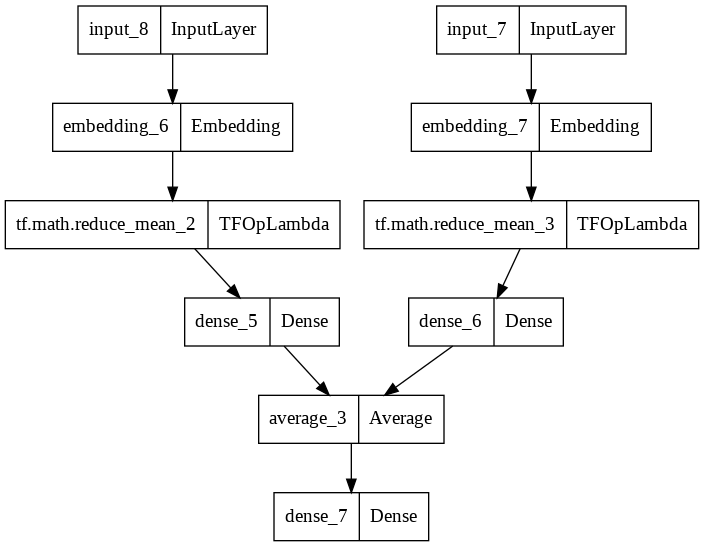

In [42]:
keras.utils.plot_model(model_bag_of_words, "bag_of_words.png")

# Training

##Metrics and model parameters

In [212]:
metrics = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=2, threshold=0.5),
           tfa.metrics.CohenKappa(num_classes=2, sparse_labels=False)
           ]

sgdopt = tf.keras.optimizers.SGD(learning_rate=0.1)
adamopt = keras.optimizers.Adam(0.001)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=3)

##1st model training

In [44]:
model_RNN_last.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer= adamopt,
    metrics=metrics
)

RNN_last_history = model_RNN_last.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=1024, shuffle=False, epochs=10, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

Epoch 1/10


ValueError: ignored

##2nd model training

In [ ]:
model_RNN_mean.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=metrics
)

RNN_mean_history = model_RNN_mean.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=1024, shuffle=True, epochs=10, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

loss: 0.3243 - tp: 106566.0000 - fp: 16242.0000 - tn: 105498.0000 - fn: 15174.0000 - accuracy: 0.8710 - auc: 0.9342 - val_loss: 0.6672 - val_tp: 5183.0000 - val_fp: 2038.0000 - val_tn: 5127.0000 - val_fn: 1982.0000 - val_accuracy: 0.7195 - val_auc: 0.7697


##3rd model training

In [73]:
mergings = ['mean', 'sum', 'concat']

### Mean Merging

Model: "mlp_mean"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_70 (InputLayer)          [(None, 65)]         0           []                               
                                                                                                  
 input_69 (InputLayer)          [(None, 209)]        0           []                               
                                                                                                  
 embedding_68 (Embedding)       (None, 65, 100)      2480300     ['input_70[0][0]']               
                                                                                                  
 embedding_69 (Embedding)       (None, 209, 100)     3796900     ['input_69[0][0]']               
                                                                                           

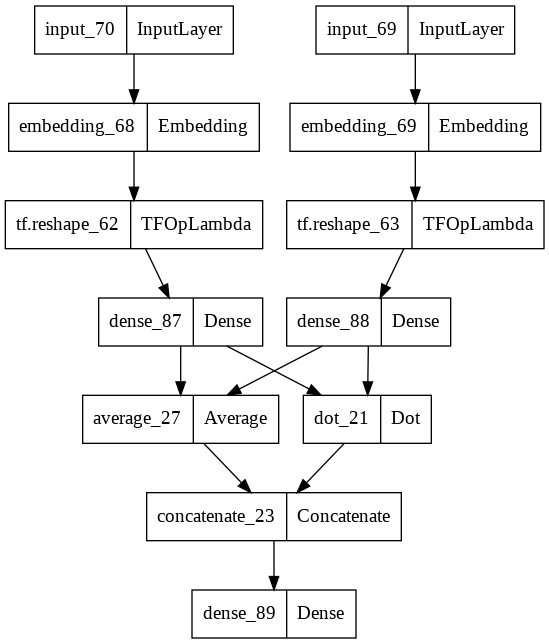

In [200]:
model_MLP_mean = create_mlp_model(mergings[0])
model_MLP_mean.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=adamopt,
    metrics=metrics
)

model_MLP_mean.summary()
keras.utils.plot_model(model_MLP_mean, "MLP_mean.png")

In [ ]:
mean_MLP_history = model_MLP_mean.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=512, callbacks=[es_callback], shuffle=True, epochs=15, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

Batch 512 - Epoch 15 - 63s 265ms/step 
- **train** 
  - loss: 0.3023 
  - accuracy: 0.8754 
  - auc: 0.9445
  - f1_score: 0.8265
  - cohen_kappa: -0.5487
- **val** 
  - loss: 0.5790 
  - val_accuracy: 0.7274 
  - val_auc: 0.8073 
  - val_f1_score: 0.7165 
  - val_cohen_kappa: -0.9260

### Sum Merging

Model: "mlp_sum"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 65)]         0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 209)]        0           []                               
                                                                                                  
 embedding_70 (Embedding)       (None, 65, 100)      2480300     ['input_72[0][0]']               
                                                                                                  
 embedding_71 (Embedding)       (None, 209, 100)     3796900     ['input_71[0][0]']               
                                                                                            

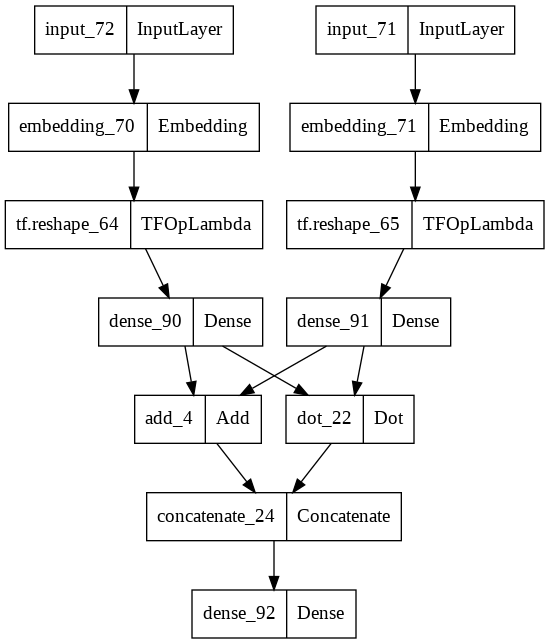

In [204]:
model_MLP_sum = create_mlp_model(mergings[1])
model_MLP_sum.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=adamopt,
    metrics=metrics
)

model_MLP_sum.summary()
keras.utils.plot_model(model_MLP_sum, "MLP_sum.png")

In [209]:
sum_MLP_history = model_MLP_sum.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=512, callbacks=[es_callback], shuffle=True, epochs=15, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

Epoch 1/15
238/238 [==============================] - 67s 283ms/step - loss: 0.3400 - tp: 104050.0000 - fp: 17690.0000 - tn: 104050.0000 - fn: 17690.0000 - accuracy: 0.8547 - auc: 0.9276 - f1_score: 0.7954 - cohen_kappa: -0.5507 - val_loss: 0.5171 - val_tp: 5309.0000 - val_fp: 1856.0000 - val_tn: 5309.0000 - val_fn: 1856.0000 - val_accuracy: 0.7410 - val_auc: 0.8235 - val_f1_score: 0.7401 - val_cohen_kappa: -0.9937
Epoch 2/15
238/238 [==============================] - 67s 283ms/step - loss: 0.3231 - tp: 105093.0000 - fp: 16647.0000 - tn: 105093.0000 - fn: 16647.0000 - accuracy: 0.8633 - auc: 0.9348 - f1_score: 0.8084 - cohen_kappa: -0.5546 - val_loss: 0.6507 - val_tp: 5041.0000 - val_fp: 2124.0000 - val_tn: 5041.0000 - val_fn: 2124.0000 - val_accuracy: 0.7036 - val_auc: 0.7826 - val_f1_score: 0.6822 - val_cohen_kappa: -0.8741
Epoch 3/15
238/238 [==============================] - 68s 284ms/step - loss: 0.3295 - tp: 104850.0000 - fp: 16890.0000 - tn: 104850.0000 - fn: 16890.0000 - accura

Batch 512 - Epochs 15 - 63s 265ms/step 
- **train** 
  - loss: 0.3304 
  - accuracy: 0.8610
  - auc: 0.9311
  - f1_score: 0.8095
  - cohen_kappa: -0.5749
- **val** 
  - loss: 0.5171
  - val_accuracy: 0.7431 
  - val_auc: 0.8235 
  - val_f1_score: 0.7404 
  - val_cohen_kappa: -0.8488

### Concatenation Merging

Model: "mlp_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_74 (InputLayer)          [(None, 65)]         0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None, 209)]        0           []                               
                                                                                                  
 embedding_72 (Embedding)       (None, 65, 100)      2480300     ['input_74[0][0]']               
                                                                                                  
 embedding_73 (Embedding)       (None, 209, 100)     3796900     ['input_73[0][0]']               
                                                                                         

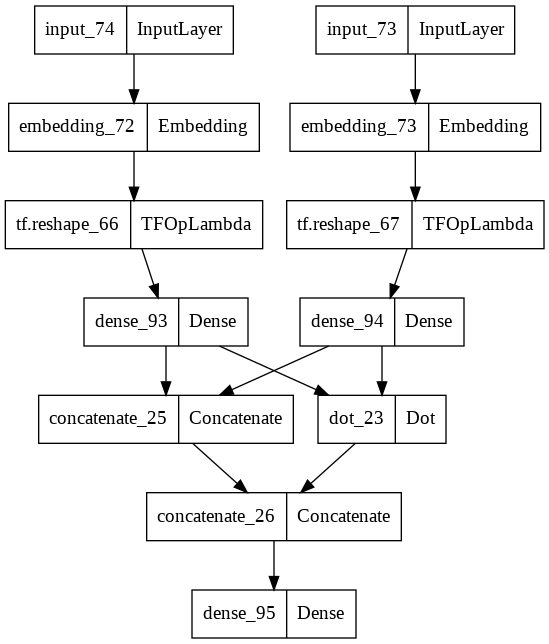

In [210]:
model_MLP_concat = create_mlp_model(mergings[2])
model_MLP_concat.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=adamopt,
    metrics=metrics
)

model_MLP_concat.summary()
keras.utils.plot_model(model_MLP_concat, "MLP_concat.png")

In [213]:
concat_MLP_history = model_MLP_concat.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=512, callbacks=[es_callback], shuffle=True, epochs=15, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

Epoch 1/15
238/238 [==============================] - 68s 285ms/step - loss: 0.3624 - tp: 102875.0000 - fp: 18865.0000 - tn: 102875.0000 - fn: 18865.0000 - accuracy: 0.8450 - auc: 0.9193 - f1_score: 0.7701 - cohen_kappa: -0.5084 - val_loss: 0.5475 - val_tp: 5144.0000 - val_fp: 2021.0000 - val_tn: 5144.0000 - val_fn: 2021.0000 - val_accuracy: 0.7179 - val_auc: 0.8027 - val_f1_score: 0.7062 - val_cohen_kappa: -0.9232
Epoch 2/15
238/238 [==============================] - 67s 280ms/step - loss: 0.3584 - tp: 103228.0000 - fp: 18512.0000 - tn: 103228.0000 - fn: 18512.0000 - accuracy: 0.8479 - auc: 0.9199 - f1_score: 0.7808 - cohen_kappa: -0.5311 - val_loss: 0.6340 - val_tp: 4933.0000 - val_fp: 2232.0000 - val_tn: 4933.0000 - val_fn: 2232.0000 - val_accuracy: 0.6885 - val_auc: 0.7796 - val_f1_score: 0.6625 - val_cohen_kappa: -0.8569
Epoch 3/15
238/238 [==============================] - 67s 282ms/step - loss: 0.3621 - tp: 103304.0000 - fp: 18436.0000 - tn: 103304.0000 - fn: 18436.0000 - accura

Batch 512 - Epoch 10 - 63s 282ms/step 
- **train** 
  - loss: 0.3624
  - accuracy: 0.8450
  - auc: 0.9193
  - f1_score: 0.7701
  - cohen_kappa: -0.5108
- **val** 
  - loss: 0.5475
  - val_accuracy: 0.7179
  - val_auc: 0.8073 
  - val_f1_score: 0.7062 
  - val_cohen_kappa: -0.9232

##4th model training

In [ ]:
model_bag_of_words.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=metrics
)

bag_of_words_history = model_bag_of_words.fit([train_claims_X, train_evidences_X], train_labels_y, batch_size=128, shuffle=True, epochs=15, validation_data=([val_claims_X, val_evidences_X], val_labels_y))

#Model Evaluation

In [74]:
target_names = ['SUPPORT', 'REFUTES'] 

##RNN last state


In [ ]:
ev = model_RNN_mean.evaluate((test_claims_X, test_evidences_X), test_labels_y, verbose=1)

##RNN mean state

In [ ]:
ev = model_RNN_mean.evaluate((test_claims_X, test_evidences_X), test_labels_y, verbose=1)

##MLP

### Mean

In [214]:
ev_MLP_mean = model_MLP_mean.predict((test_claims_X, test_evidences_X))  
pred_mean = np.around(ev_MLP_mean)

Multi-input classification evaluation

In [216]:
print(classification_report(test_labels_y, pred_mean, target_names=target_names))

              precision    recall  f1-score   support

     SUPPORT       0.65      0.91      0.76      3606
     REFUTES       0.85      0.51      0.64      3583

   micro avg       0.71      0.71      0.71      7189
   macro avg       0.75      0.71      0.70      7189
weighted avg       0.75      0.71      0.70      7189
 samples avg       0.71      0.71      0.71      7189



Claim verification evaluation

### Sum

In [218]:
ev_MLP_sum = model_MLP_sum.predict((test_claims_X, test_evidences_X))  
pred_sum = np.around(ev_MLP_sum)

Multi-input classification evaluation

In [219]:
print(classification_report(test_labels_y, pred_sum, target_names=target_names))

              precision    recall  f1-score   support

     SUPPORT       0.83      0.32      0.46      3606
     REFUTES       0.58      0.94      0.71      3583

   micro avg       0.62      0.62      0.62      7189
   macro avg       0.70      0.63      0.59      7189
weighted avg       0.70      0.62      0.59      7189
 samples avg       0.62      0.62      0.62      7189



Claim verification evaluation

### Concatenation

In [221]:
ev_MLP_concat = model_MLP_concat.predict((test_claims_X, test_evidences_X))  
pred_concat = np.around(ev_MLP_concat)

Multi-input classification evaluation

In [222]:
print(classification_report(test_labels_y, pred_concat, target_names=target_names))

              precision    recall  f1-score   support

     SUPPORT       0.61      0.97      0.74      3606
     REFUTES       0.92      0.37      0.52      3583

   micro avg       0.67      0.67      0.67      7189
   macro avg       0.76      0.67      0.63      7189
weighted avg       0.76      0.67      0.64      7189
 samples avg       0.67      0.67      0.67      7189



Claim verification evaluation

###Bag of words

In [ ]:
ev_bag_of_words = model_bag_of_words.predict((test_claims_X, test_evidences_X))                                                                                                                                                                           
pred_bag = np.around(ev_bag_of_words)

In [ ]:
print(classification_report(test_labels_y, pred_bag, target_names=target_names))